# NMT with Attention Mechanism for ENG to ASL

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/My Drive/Minor Project

/content/drive/My Drive/Minor Project


In [10]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import unicodedata
import re
import numpy as np
import os
import io
import time
path_to_file = "data/train.txt"

<ul>
<h3><li>Functions and Utilities</li></h3>

In [11]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Function to preprocess the languages
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)    
    w = re.sub(r'[" "]+', " ", w)             # creating a space between a word and the punctuation following it
    w = re.sub(r"[^a-zA-Z?.!,¿-]+", " ", w)   # replace everything with space except (a-z, A-Z, ".", "?", "!", ",","-")
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'   # adding a start and an end token to the sentence
    return w

# Function to create dataset
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs)  #Creating a map (ASL,ENG)

#To find the maximum length
def max_length(tensor):
    return max(len(t) for t in tensor)

#Word tokenizer
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')   #Pads the sequences to the same length
  return tensor, lang_tokenizer


def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

#for displaying word with corresponding corpus index
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:   #Record operations for automatic differentiation. Eager Execution enabled. No use TF graph for Back Propagation.
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)    #Custom Loss Function

  dec_input = tf.expand_dims(targ[:, t], 1)
  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))   #Gradients are calculated and applied w/o graph.. Eager Execution

  return batch_loss

'''
Advantages of Eager Execution TF
1. An intuitive interface
2. Easier debugging
3. Natural control flow
'''
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')    #Padding the i/p signal
    inputs = tf.convert_to_tensor(inputs)           
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
       # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted ASL translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    return result

def loss_function(real, pred):                          #Custom Loss function
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


<ul>
<li><h3>Model Creation</h3></li>

In [12]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)  #Turns positive integers (indexes) into dense vectors of fixed size.
    self.gru = tf.keras.layers.GRU(self.enc_units,                        # [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]   
                                   return_sequences=True,                
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') #Default : Tanh

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

class BahdanauAttention(tf.keras.Model):   #Attention Layer
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score

    hidden_with_time_axis = tf.expand_dims(query, 1)    # t.shape =[2] --> t.shape = [2,1] 

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [6]:
asl, eng = create_dataset(path_to_file, None)

KeyboardInterrupt: ignored

In [13]:
num_examples = 60000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1  # 17446
vocab_tar_size = len(targ_lang.word_index)+1  #13097

# Generate batches
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

#Tensor Shapes
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

<ul>
<li><h3>Word Mappings in Corpus</h3></li>

In [ ]:

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
11 ----> this
8 ----> is
48 ----> very
64 ----> important
16 ----> for
4 ----> the
2059 ----> achievement
6 ----> of
31 ----> our
191 ----> common
2584 ----> ideal
4 ----> the
2584 ----> ideal
6 ----> of
12 ----> a
354 ----> united
56 ----> europe
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
10 ----> this
4 ----> be
42 ----> desc-very
58 ----> desc-important
14 ----> for
1369 ----> achievement
7 ----> x-we
198 ----> desc-common
1923 ----> ideal
1923 ----> ideal
370 ----> unite
52 ----> europe
3 ----> .
2 ----> <end>



<ul>
<h3><li>Models Objects</li></h3>

In [15]:
BATCH_SIZE = 64
embedding_dim = 256
units = 1024

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')    # Normal Vector Embeddings not One Hot encoding.. Hence Sparse...

#SparseCategoricalCrossentropy is used for NON-One hot encoded i/o. For One-Hot encoded I/O Catergorical Cross Entropy is used. 
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

attention_layer = BahdanauAttention(10)


decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)



In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

<ul>
<h3><li>Training Section</h3>

In [16]:
checkpoint_dir = './training_checkpoints_10_final'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                  decoder=decoder)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# EPOCHS = 5

# for epoch in range(EPOCHS):
#   start = time.time()
#   enc_hidden = encoder.initialize_hidden_state()
#   total_loss = 0
#   for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
#     batch_loss = train_step(inp, targ, enc_hidden)
#     total_loss += batch_loss
#     if batch % 100 == 0:
#         print('Epoch {} Batch {} '.format(epoch + 1,batch))
#   # saving (checkpoint) the model every 2 epochs

#   print('Epoch {} Loss {:.4f}'.format(epoch + 1,
#                                       total_loss / steps_per_epoch))
    
#   if (epoch + 1) % 5 == 0:
#     checkpoint.save(file_prefix = checkpoint_prefix)

#   print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


In [ ]:
# restoring the latmest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> i declare the session of the european parliament suspended . <end>
Predicted ASL translation: x-i declare session european parliament suspend . <end> 


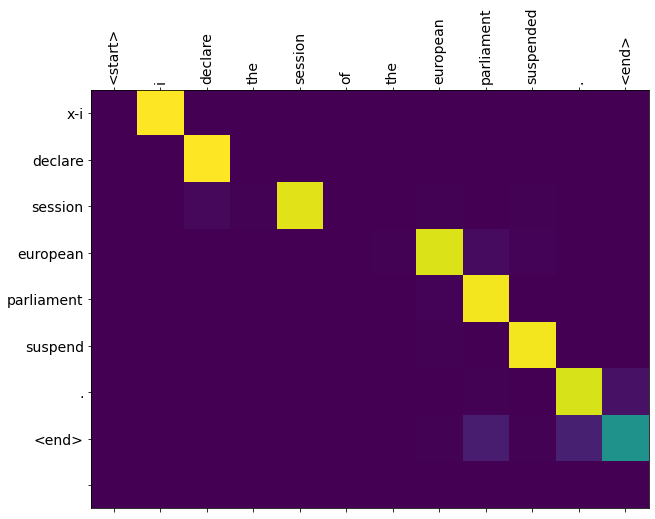

'x-i declare session european parliament suspend . <end> '

In [ ]:
translate(u'i declare the session of the european parliament suspended.')

Input: <start> president is good person <end>
Predicted ASL translation: president be desc-good person <end> 


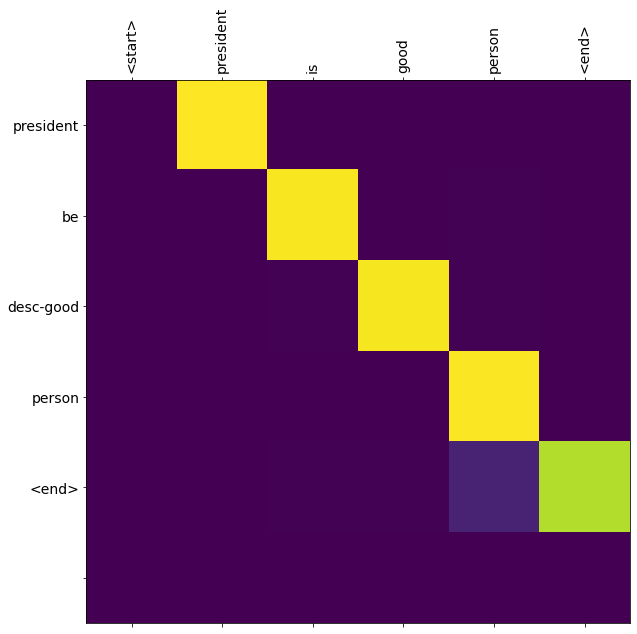

'president be desc-good person <end> '

In [ ]:
translate(u'president is good person')

Input: <start> the sitting was closed at evening <end>
Predicted translation: sit be desc-close at evening <end> 


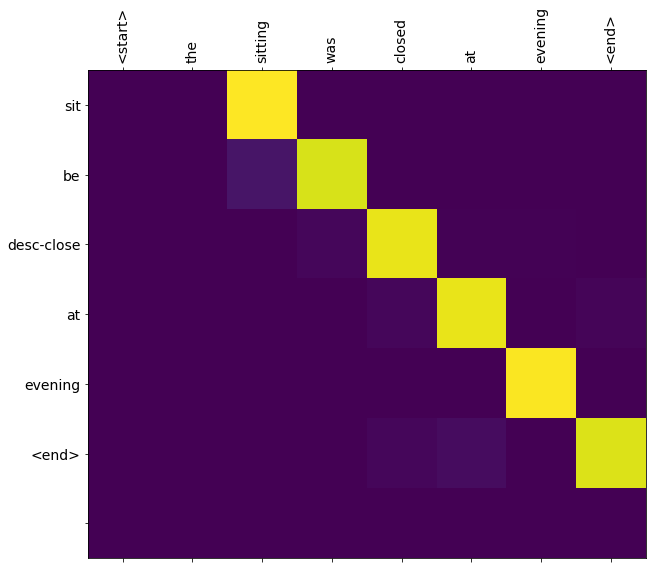

sit be desc-close at evening <end> 
0.7598356856515925


In [ ]:
import nltk
english = u'the sitting was closed at evening'
asl_expected = 'SIT BE DESC-CLOSE AT EVENING'
asl_expected = asl_expected.lower()
asl_translated  = translate(english)

print(asl_translated)
hypothesis = asl_translated.split()
reference = asl_expected.split()
#there may be several references

BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print (BLEUscore)

Input: <start> it is a good country . <end>
Predicted translation: x-it be desc-good country . <end> 


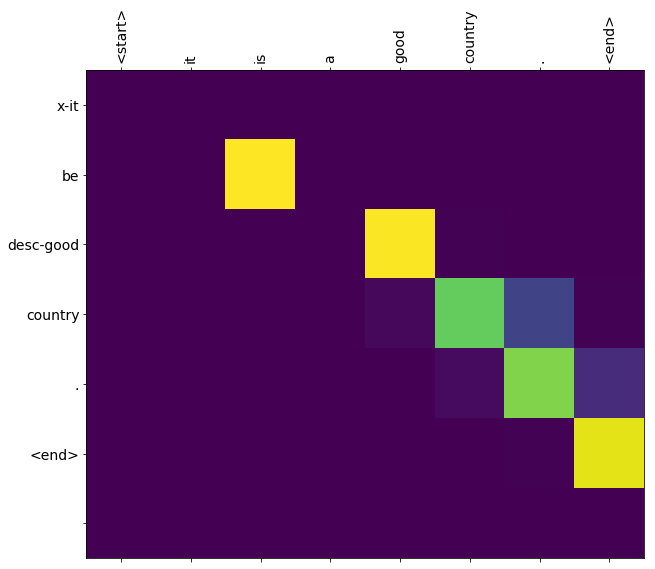

'x-it be desc-good country . <end> '

In [ ]:
translate('it is a good country.')

Input: <start> america is a strong country <end>
Predicted translation: america be desc-strong country <end> 


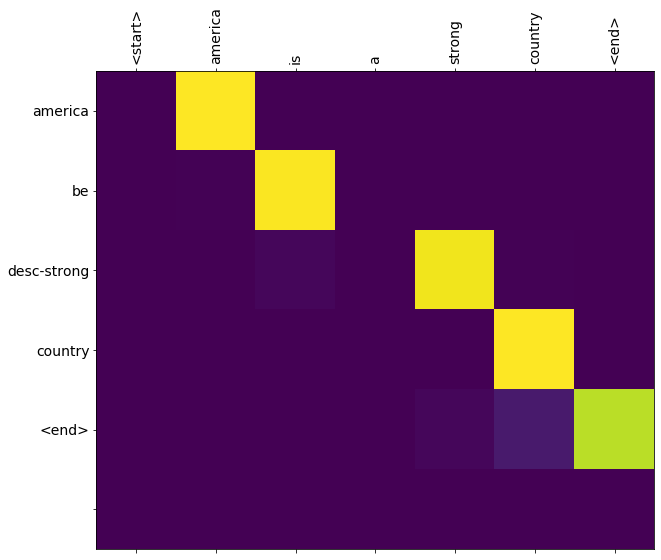

'america be desc-strong country <end> '

In [ ]:
translate(u'america is a strong country')

Input: <start> america has encouraged mission <end>
Predicted translation: america have encourage mission <end> 


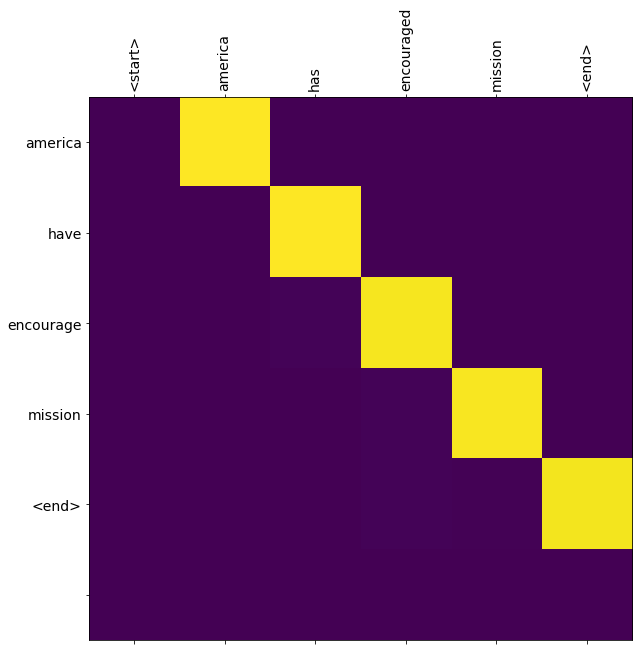

'america have encourage mission <end> '

In [ ]:
translate(u'america has encouraged mission')